# Efficient Frontier Portfolio Optimisation for Strategic Asset Allocation 
- *by Chee-Foong*
- *Mar 2020*

## Importing libraries and functions
- yfinance==0.1.54
- scikit-image==0.15.0
- scikit-learn==0.21.3
- scipy==1.4.1
- seaborn==0.9.0
- pandas==0.25.3
- pyportfolioopt==0.5.4
- matplotlib==3.1.3
- numpy==1.17.2
- pyfolio==0.9.2


In [29]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys  
sys.path.append('../src') 
from edge import *

In [30]:
import numpy as np
import pandas as pd

# Import the plotting library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

import seaborn as sns; sns.set()
plt.style.use('ggplot')

## Extracting Data from Yahoo
Select list of interested yahoo tickers

In [31]:
tickers = ['LQD','HYG','EFA','^RUA','AGG','^GSPC','GLD','GOVT','SPY','QQQ','EMB',
          'AAPL','GOOG','TSLA','FB','NVDA','AMD','BABA','MSFT','AMZN']

Extracting data from yahoo

In [32]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start="2019-01-01", end="2020-04-01")

[*********************100%***********************]  20 of 20 completed


Filtering data for this analysis
- by tickers
- by dates
- by price type

In [33]:
tickers = ['AGG','SPY','GLD','HYG','GOVT']

In [34]:
prices = data['2018':'2020']['Adj Close'][tickers]
returns = prices.pct_change().dropna()
# returns = np.log(prices/prices.shift(1)).dropna()
cum_returns = ((1 + returns).cumprod()-1) 

In [35]:
prices

,AGG,SPY,GLD,HYG,GOVT
Date,,,,,
2018-12-31,103.176964,245.275513,121.250000,76.419067,24.092072
2019-01-02,103.254471,245.530655,121.330002,76.315399,24.287537
2019-01-03,103.680763,239.671631,122.430000,76.353119,24.424374
2019-01-04,103.370743,247.699615,121.440002,77.634598,24.297314
2019-01-07,103.196350,249.652634,121.860001,78.388451,24.248444
...,...,...,...,...,...
2020-03-12,110.129997,248.110001,147.789993,77.610001,27.590000
2020-03-13,111.860001,269.320007,143.279999,80.050003,27.430000
2020-03-16,113.730003,239.850006,141.639999,75.650002,27.870001


## Data Exploratory 
Show for each asset
- Annualised Return (%)
- Annualised Volatility (%)
- Sharpe Ratio

In [36]:
prettyAnalytics(returns, tickerlist)

,Annualised Return (%),Annualised Volatility (%),Sharpe Ratio
index,,,
iShares U.S. Treasury Bond ETF,10.4846,5.56079,1.88545
SPDR Gold Trust,14.0041,13.4323,1.04257
iShares Core U.S. Aggregate Bon,5.71489,6.09439,0.93773
SPDR S&P 500,2.38275,24.36,0.0978138
iShares iBoxx $ High Yield Corp,-1.76161,10.1029,-0.174366


Displaying the cumulative returns over the period

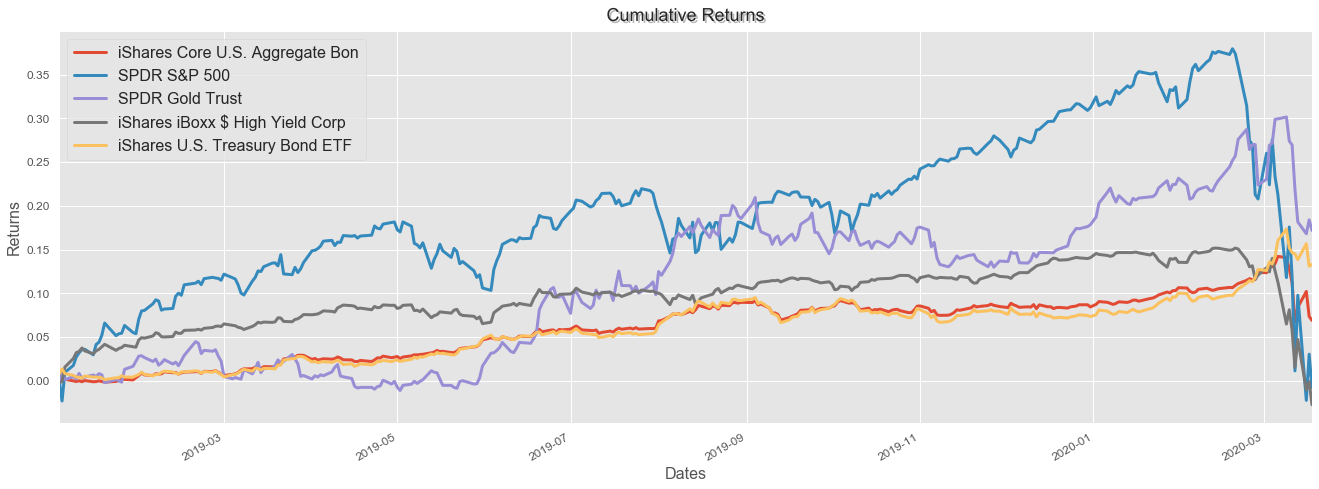

In [37]:
plotTimeSeries(cum_returns, 'Cumulative Returns', 'Dates', 'Returns', tickerlist)

Comparing the return distribution of the assets

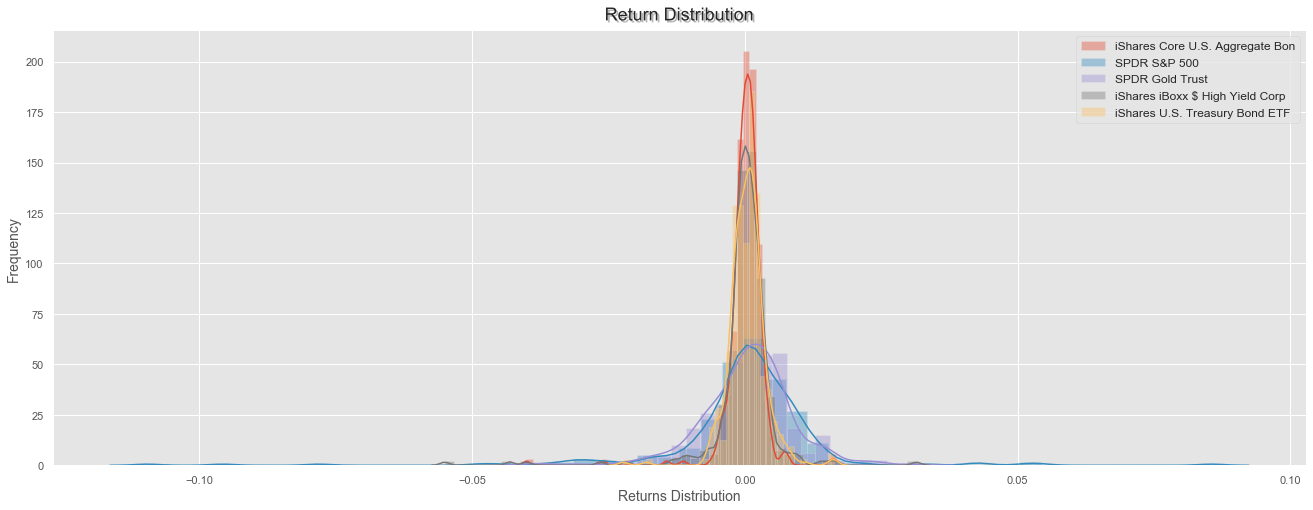

In [38]:
compareDistribution(returns, tickers, title='Return Distribution', tickermap = tickerlist)

In [39]:
def plotReturnDistribution2(returns, ticker, binsize=35, title=''):
    
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax.hist(returns[ticker], bins=binsize, color='steelblue', density = True,
             alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

    title_text_obj = ax.set_title(title, fontsize = 18, verticalalignment = 'bottom')
    title_text_obj.set_path_effects([patheffects.withSimplePatchShadow()])

    sigma, mu = returns[ticker].std(), returns[ticker].mean() # mean and standard deviation
    s = np.random.normal(mu, sigma, 1000)

    count, bins, ignored = ax.hist(s, binsize, density=True, alpha = 0.1)
    ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
            linewidth=1.5, color='r')

    ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns[ticker].skew(),2),
                                                       round(returns[ticker].kurtosis(),2)),
                 xy=(10,20), xycoords = 'axes points', xytext =(20,360), fontsize=14)

    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    
    plt.show()


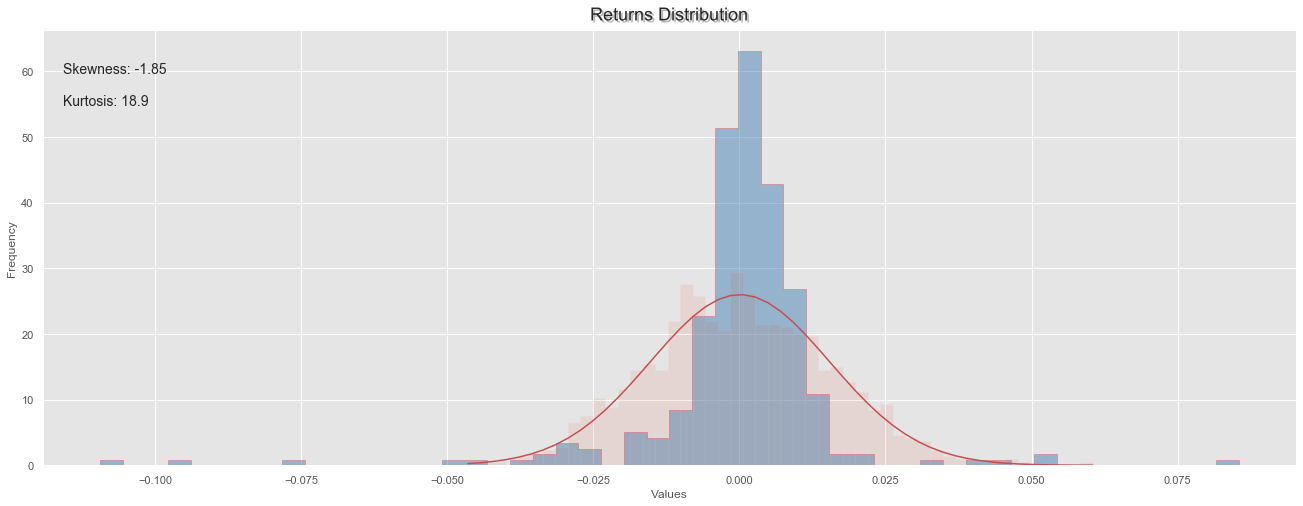

In [40]:
plotReturnDistribution(returns, 'SPY', 50, 'Returns Distribution')

Correlation Matrix of the assets

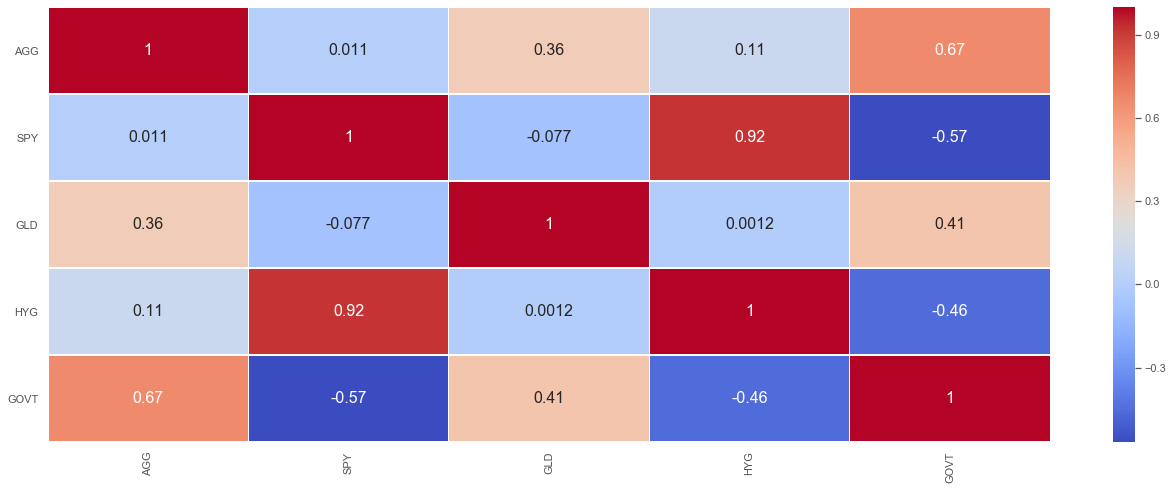

In [41]:
correlation_matrix = returns.corr('pearson')
plotCorrelationMatrix(correlation_matrix, 3)

## Plotting the Efficient Frontier
- Simulate asset allocation by random assigning of weights

An simulated example

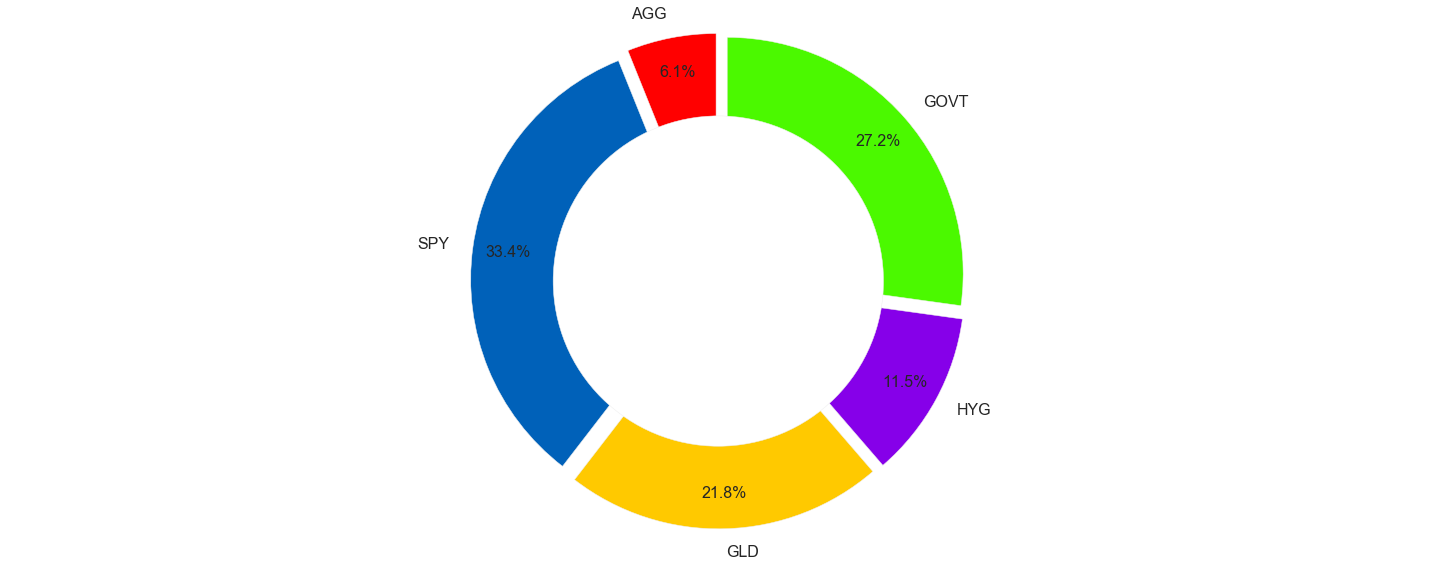

In [42]:
allocation = pd.DataFrame(data = {'Simulated': generateWgts(len(tickers)), 
                                  'Balanced': 1/len(tickers) * np.ones(len(tickers))},
                          index = tickers)
drawPie(allocation, 'Simulated', tickers)

Simulated returns of 5 portfolios and plotting their respective cumulative returns series 

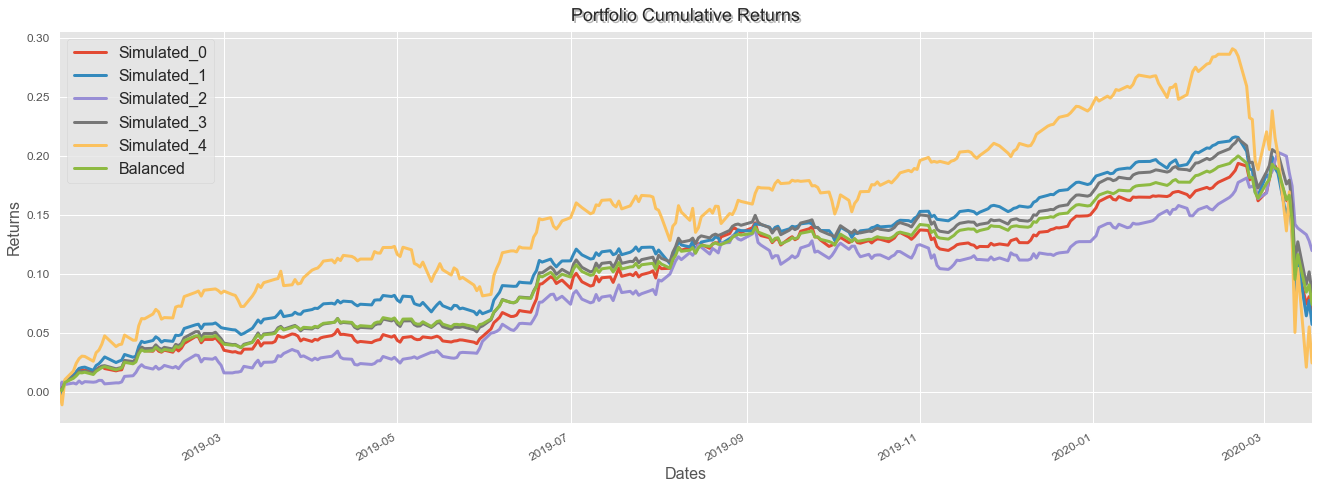

In [43]:
allocation = simAllocation(5, tickers)
port_returns = returns.dot(allocation)
port_cum_returns = ((1 + port_returns).cumprod()-1) 
plotTimeSeries(port_cum_returns, 'Portfolio Cumulative Returns', 'Dates', 'Returns')

Set the number of simulated portfolios and plotting the efficient frontier

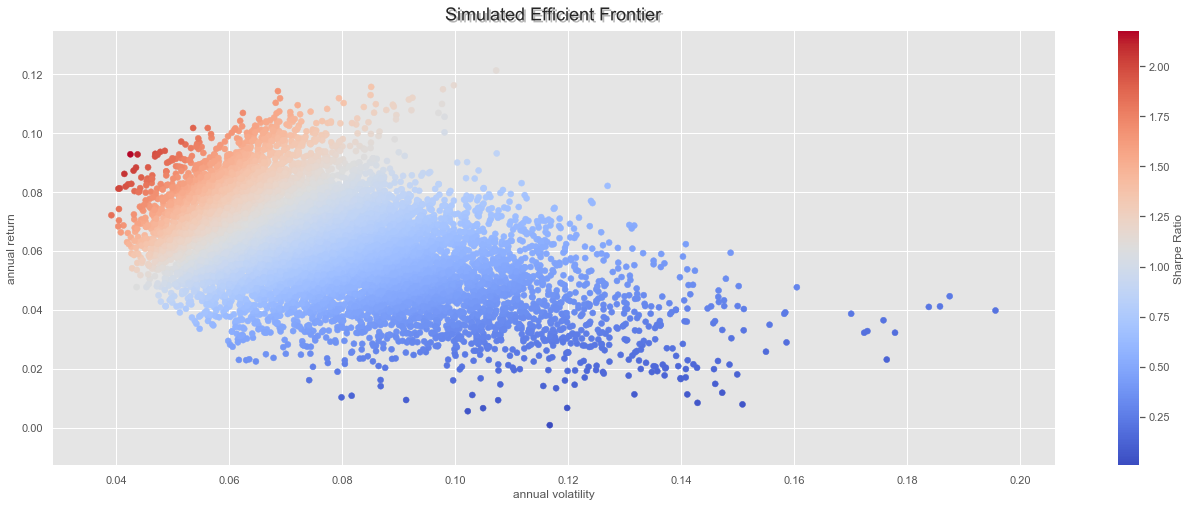

In [44]:
NUM_OF_SIMULATION = 10000
plotEfficientFrontier(returns, tickers, NUM_OF_SIMULATION)

## Finding the optimal portfolio

- Using PyPortfolioOpt python library for portfolio optimization
- to find portfolio with minimum volatility and max sharpe ratio

In [45]:
# !pip install PyPortfolioOpt
# prettyAnalytics(returns, tickerlist)

# Import the packages 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

### Build efficient frontier model using PyPortfolioOpt

In [46]:
# Calculate expected returns
expected_returns_daily = expected_returns.mean_historical_return(prices)

# Calculate the covariance matrix
covariance_matrix = risk_models.sample_cov(prices)

# Obtain the efficient frontier
ef = EfficientFrontier(expected_returns_daily, covariance_matrix)

### Performance numbers at maximum sharpe ratio

In [47]:
# Select a chosen optimal portfolio
ef.max_sharpe(risk_free_rate=0.00)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.0, 'SPY': 0.12089, 'GLD': 0.00054, 'HYG': 0.0, 'GOVT': 0.87857}
Expected annual return: 9.5%
Annual volatility: 4.0%
Sharpe Ratio: 2.36


(0.09507081379723203, 0.04025890282399064, 2.3614854635476674)

### Performance numbers at minimum volatility
**Important Note:** Issue raised due to bug in minimum volatility calculations 
- https://github.com/robertmartin8/PyPortfolioOpt/issues/75

In [48]:
# Select a chosen portfolio with minimal volatiliy
ef.min_volatility()
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.0, 'SPY': 0.00593, 'GLD': 0.0, 'HYG': 0.28198, 'GOVT': 0.71209}
Expected annual return: 7.0%
Annual volatility: 3.7%
Sharpe Ratio: 1.89


(0.06983362204931864, 0.036923590982111745, 1.8913009323267262)

### Plotting the efficient frontier
- using increasing volatility steps (vsteps)
- vsteps set at 0.0005
- risk-free rate (rf) set at 0.0

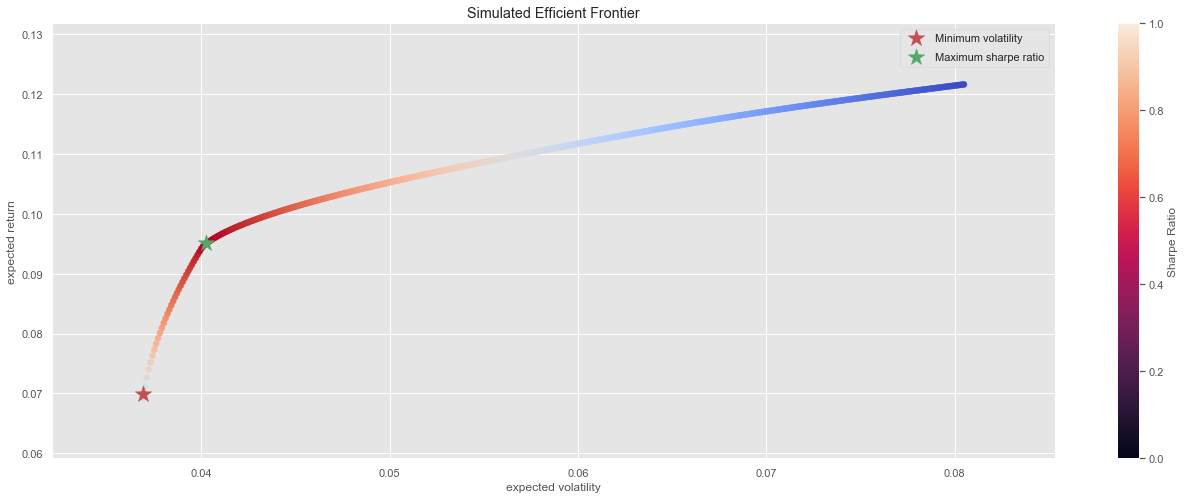

In [49]:
plotEF(ef, vsteps=0.0001, rf=0.0)

## Portfolio Asset Allocation
- Based on range of returns and volatility on the efficient frontier
- Select either your preferred target return or target volatility to derive the weights of your portfolio

In [50]:
TARGET_RETURN = 0.06

# Select a minimal risk for a target return
ef.efficient_return(TARGET_RETURN)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.0, 'SPY': 0.0, 'GLD': 0.0, 'HYG': 0.3662, 'GOVT': 0.6338}
Expected annual return: 6.0%
Annual volatility: 3.8%
Sharpe Ratio: 1.59


(0.05999999997972963, 0.03770119837363151, 1.591461347862461)

### Performance numbers at targeted risk 

In [51]:
TARGET_RISK = 0.04

# Select an optimal return for a target risk
ef.efficient_risk(TARGET_RISK, risk_free_rate = 0.00)
print('Weights: {}'.format(ef.clean_weights()))

# Obtain the performance numbers
ef.portfolio_performance(verbose=True, risk_free_rate = 0.00)

Weights: {'AGG': 0.0, 'SPY': 0.13043, 'GLD': 0.0, 'HYG': 0.00042, 'GOVT': 0.86915}
Expected annual return: 9.4%
Annual volatility: 4.0%
Sharpe Ratio: 2.36


(0.0942267270053632, 0.04000000006580154, 2.3556681712589156)

## Portfolio Performance and Risk Analysis
Using Portfolio Weights of **Maximum Sharpe Ratio**

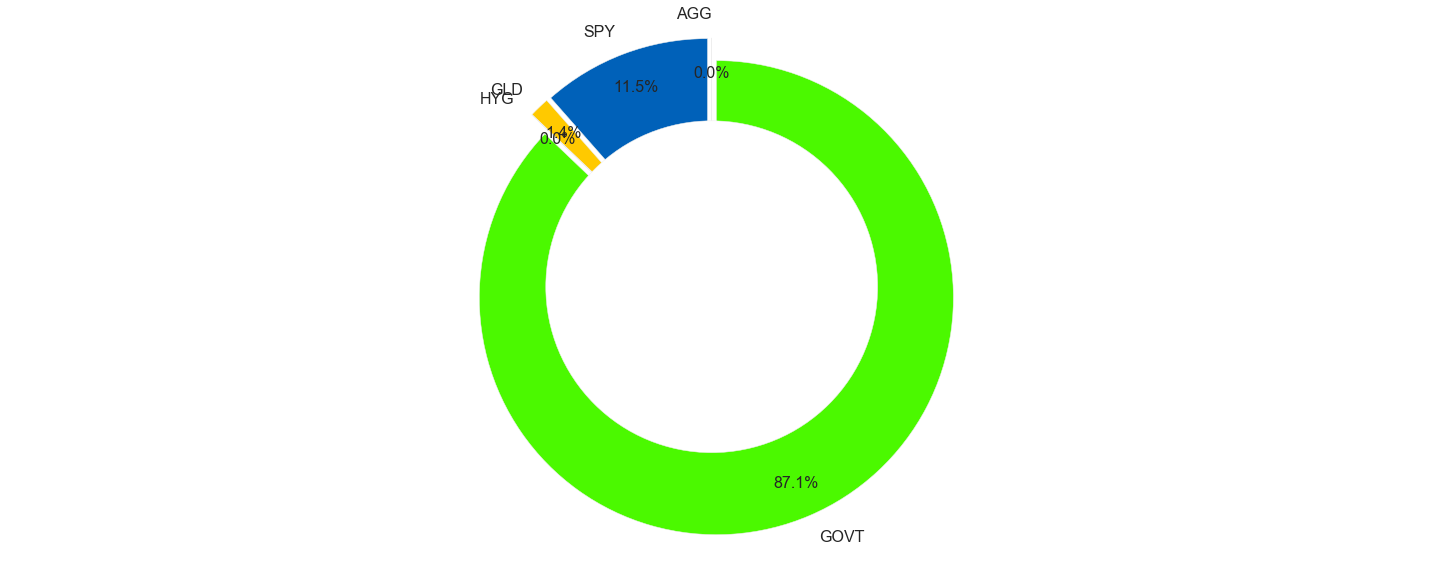

In [52]:
selected_allocation = pd.DataFrame.from_dict(ef.max_sharpe(), 
                                             orient='index', columns=['Optimal'])
drawPie(selected_allocation, 'Optimal', tickers)

### Tear sheet of the optimal portfolio returns by Pyfolio

Start date,2019-01-02
End date,2020-03-18
Total months,14
,Backtest
Annual return,10.0%
Cumulative returns,12.2%
Annual volatility,4.1%
Sharpe ratio,2.36
Calmar ratio,2.37
Stability,0.94
Max drawdown,-4.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.22,2020-03-09,2020-03-18,NaT,NaN
1,2.09,2019-09-04,2019-09-13,2020-01-03,88
2,0.83,2019-07-03,2019-07-11,2019-08-01,22
3,0.62,2019-03-29,2019-04-16,2019-04-26,21
4,0.58,2019-02-26,2019-03-01,2019-03-12,11


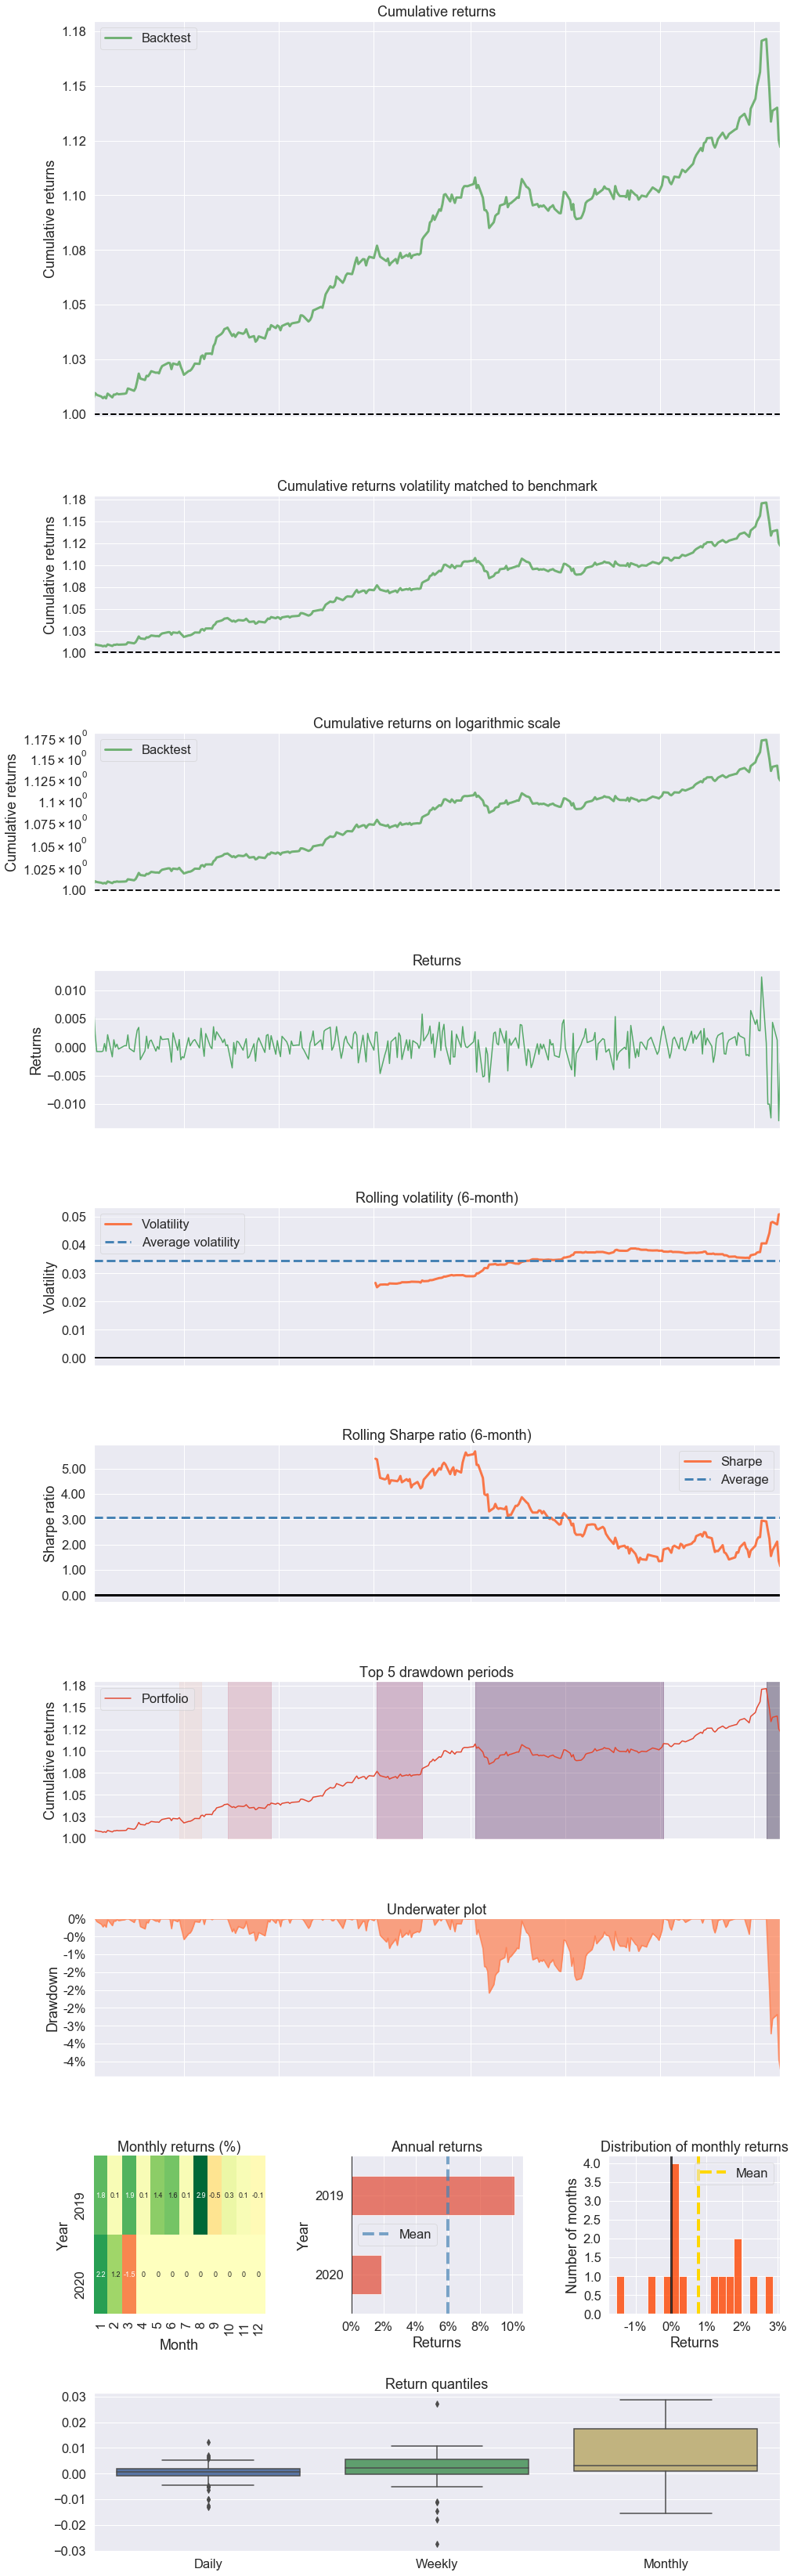

In [53]:
# !pip install pyfolio
# Import the package
import pyfolio as pf

selected_port_returns = returns.dot(selected_allocation)
pyfolio_returns = pd.Series(selected_port_returns['Optimal'], index=selected_port_returns.index)
pyfolio_returns.index=pd.to_datetime(pyfolio_returns.index)

pf.create_returns_tear_sheet(pyfolio_returns)

# Next Steps...

- Exponentially weighted returns
- Exponentially weighted covariance
- Using downside risk in the optimization - Sortino Ratio

In [54]:
# from pypfopt import expected_returns

# # Exponentially weighted moving average
# mu_ema = expected_returns.ema_historical_return(df, span=252, frequency=252)
# print(mu_ema)

# from pypfopt import risk_models

# # Exponentially weighted covariance
# Sigma_ew = risk_models.exp_cov(df, span=180, frequency=252)

# Sigma_semi = risk_models.semicovariance(df, benchmark=0, frequency=252)
#    print(Sigma_semi)



# Acknowledgment
Thank you for all your contributions
- https://github.com/robertmartin8/PyPortfolioOpt
- https://github.com/quantopian/pyfolio
- https://github.com/mscandizzo/PortfolioTheory
- https://medium.com/@mariano.scandizzo/strategic-asset-allocation-with-python-c9afef392e90
- https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
- https://blog.quantinsti.com/portfolio-management-strategy-python/

In [55]:
# ef_data = genEFdata(ef, vsteps=0.0005, rf=0.0)

In [56]:
# balanced = {}
# bal_wgts = iter(1/len(tickers) * np.ones(len(tickers)))
# for ticker in tickers:
#     balanced[ticker] = next(bal_wgts)
# balanced['index'] = 'balanced'

# wgts = [min_vol, max_sharpe, balanced]

# wgts = {}
# for i in range(0,num):
#     wgts['Simulated_' + str(i)] = generateWgts(len(tickers))
# wgts['Balanced'] = 1/len(tickers) * np.ones(len(tickers))